In [126]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
from pmdarima.arima import CHTest, nsdiffs
from pmdarima.arima import auto_arima
#from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
#import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import warnings
import time

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath
import gzip, pickle, pickletools

In [2]:
#! pip install missingno
#! pip install pmdarima

### Import data

In [127]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed/'

In [128]:
filepath = path / "df_train.pkl"
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    train_data = p.load()

In [129]:
#train_data = pd.read_pickle(path / 'df_train.pkl')
val_data = pd.read_pickle(path / 'df_val.pkl')
test_data = pd.read_pickle(path / 'df_test.pkl')

In [130]:
val_data.shape

(276569, 29)

In [131]:
train_data=train_data.groupby('date').agg({'sales':'sum'}).reset_index()
val_data=val_data.groupby('date').agg({'sales':'sum'}).reset_index()
test_data=test_data.groupby('date').agg({'sales':'sum'}).reset_index()

In [132]:
train_data.shape

(1209, 2)

## Modeling ##

In [7]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [47]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
    # replace 0s so no longer get NaN values
        actual = np.where(actual <= 0, 1, actual)
        predicted = np.where(predicted <= 0, 1, predicted)
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

## SARIMA ##

In [14]:
train_data.columns

Index(['date', 'sales'], dtype='object')

In [15]:
train_data['date'].max()

Timestamp('2016-04-26 00:00:00')

In [16]:
#shorten train for testing
train_data_sarima = train_data.set_index('date')
#shorten the train to help with training time
train_data_sarima = train_data_sarima[train_data_sarima.index > '2015-01-01']

In [17]:
#train_data_sarima = train_data_s[train_data_s['date']=='2015-09-01']
#train_data_sarima = train_data_s.set_index('date')
#val_data_sarima = val_data_s.set_index('date')

In [18]:
#train_data_sarima_exog = train_data_sarima.drop(columns=['sales'])
y_train_sarima_endog = train_data_sarima['sales']

#val_data_sarima_exog = val_data_sarima[['familycluster','cluster']]
#y_val_sarima_endog = val_data_sarima['sales']

In [20]:
val_data_sarima = val_data.set_index('date')

val_data_sarima_exog = val_data_sarima.drop(columns=['sales'])
y_val_sarima =  val_data_sarima[['sales']]

In [21]:
test_data_sarima = test_data.set_index('date')

test_data_sarima_exog = test_data_sarima.drop(columns=['sales'])
y_test_sarima =  test_data_sarima[['sales']]

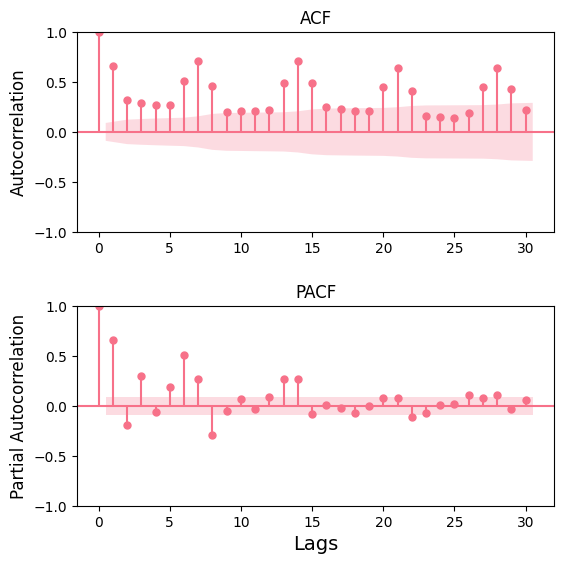

In [102]:
# Group by date to sum sales. USE IF CANT GET ANYTHING RUNNING

#ts = train_data_sarima.groupby(train_data_sarima['date'])['sales'].sum()

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(6,6))

# Plot ACF
sm.graphics.tsa.plot_acf(train_data_sarima, lags=30, ax=ax1)
ax1.set_title('ACF')
plt.xlabel('Lags', fontsize=14)
ax1.set_ylabel('Autocorrelation', fontsize=12)

# Plot PACF
sm.graphics.tsa.plot_pacf(train_data_sarima, lags=30, ax=ax2)
ax2.set_title('PACF')
ax2.set_ylabel('Partial Autocorrelation', fontsize=12)
plt.tight_layout(pad=2.0)

plt.show()

In [115]:
# Define the instance
model_sarima = sm.tsa.SARIMAX(endog=y_train_sarima_endog,  order=(1,1,1), seasonal_order=(0,1,1,7))



In [116]:
# Fit the model. started at 11:48
results_sarima = model_sarima.fit()



In [117]:
# Make predictions
#forecast_sarima = results_sarima.predict(start=len(train_data_sarima), end=len(train_data_sarima) + len(val_data_sarima) - 1, dynamic=False)

#val_forecast_sarima = results_sarima.predict(steps=pd.date_range(start=start_date_val, end=end_date_val), exog=val_data_sarima_exog)
val_forecast_sarima = results_sarima.predict(start=len(train_data_sarima), end=len(train_data_sarima) + len(val_data_sarima) - 1)


In [118]:
sarima_metrics = evaluate_forecast(y_val_sarima, val_forecast_sarima)

sarima_metrics

{'MSE': 31085763958.29182,
 'RMSE': 176311.55367216244,
 'RMSLE': 0.2932699651708731}

In [119]:
test_forecast_sarima = results_sarima.predict(start=len(train_data_sarima) + len(val_data_sarima) , end=len(train_data_sarima) + len(val_data_sarima) +len(test_data_sarima)- 1)

In [120]:
print(test_forecast_sarima.shape, test_data_sarima.shape)

(316,) (316, 1)


In [121]:
sarima_metrics = evaluate_forecast(test_data_sarima, test_forecast_sarima)

sarima_metrics

{'MSE': 43076546430.019646,
 'RMSE': 207548.9012980306,
 'RMSLE': 0.3539196048673369}

In [106]:
a = test_data_sarima.reset_index().drop(columns=['date']).squeeze()


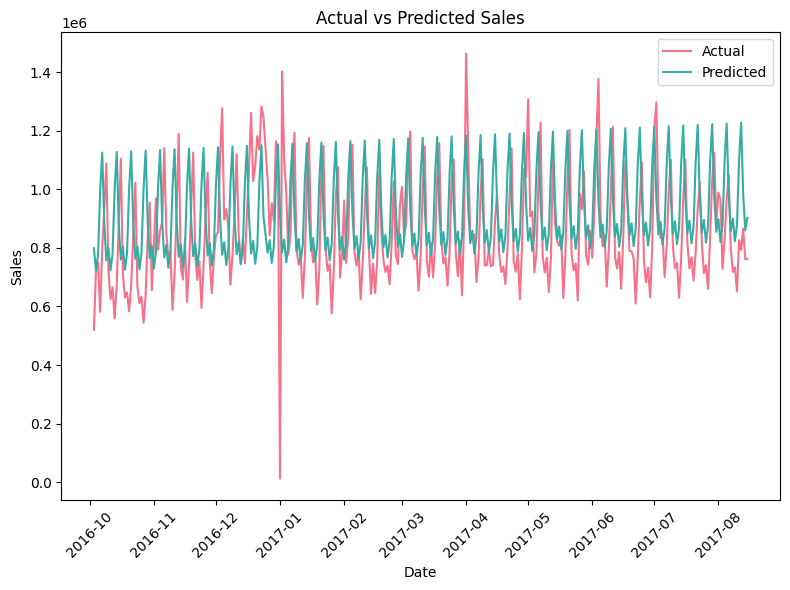

In [108]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(test_data['date'], a, label='Actual')
plt.plot(test_data['date'], test_forecast_sarima, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
y_train_sarima_endog

date
2015-01-02    6.577634e+05
2015-01-03    6.488807e+05
2015-01-04    7.309238e+05
2015-01-05    5.692673e+05
2015-01-06    4.778867e+05
                  ...     
2016-04-22    8.570592e+05
2016-04-23    1.022143e+06
2016-04-24    1.039370e+06
2016-04-25    6.800008e+05
2016-04-26    4.125245e+05
Name: sales, Length: 480, dtype: float64

In [ ]:

sarima_model = auto_arima(y_train_sarima_endog
                          #, exogenous=train_data_s[['familycluster', 'onpromotion','holiday']]
                          #, exogenous=train_data_s[['familycluster']]
                          , start_p=0 , max_p=3, start_P=0 , max_P=3 
                          , d=1 , D=1 #not sure this is a good value for d
                          , start_q=0 , max_q= 3 , start_Q=0 , max_Q=3
                          , random=True, n_fits=2
                          , seasonal=True, m=7, random_state=21, trace=True )
